# Environment Setup

In [1]:
# Install required libraries

# import sys
# !{sys.executable} -m pip install "transformers[torch]" "accelerate>=0.26.0" -U
# !pip install transformers torch scikit-learn matplotlib seaborn scipy optuna

  Using cached accelerate-1.5.2-py3-none-any.whl.metadata (19 kB)
  Using cached transformers-4.50.1-py3-none-any.whl.metadata (39 kB)
  Using cached huggingface_hub-0.29.3-py3-none-any.whl.metadata (13 kB)
  Using cached regex-2024.11.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
  Using cached tokenizers-0.21.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.8 kB)
  Using cached safetensors-0.5.3-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
Using cached accelerate-1.5.2-py3-none-any.whl (345 kB)
Using cached huggingface_hub-0.29.3-py3-none-any.whl (468 kB)
Using cached regex-2024.11.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (781 kB)
Using cached safetensors-0.5.3-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (471 kB)
Using cached tokenizers-0.21.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)
Using cached transformers-4.50.1-py3-none-any.whl (10.2 MB)
 

## Importing Libraries

In [1]:
import os
import pandas as pd
import torch
import scipy
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import train_test_split

# Disable WandB logging
os.environ["WANDB_DISABLED"] = "true"

# Load Dataset

In [ ]:
# Load the dataset
data = pd.read_csv('/data/training_data_sentiment.csv', 
                   encoding='unicode_escape',
                   names=['Sentiment', 'Text'])

data.head()

,Sentiment,Text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [4]:
data.shape  # (4846, 2)

(4846, 2)

# Data Preparation

In [5]:
# Convert string labels to numeric labels (negative -> 0, neutral -> 1, positive -> 2)
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
data['Sentiment'] = data['Sentiment'].map(label_mapping)

In [6]:
X = data['Text'].to_list()  # List of headlines
y = data['Sentiment'].to_list()  # Corresponding sentiments

In [7]:
# Split the data into train and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Load FinBERT

In [8]:
# Load FinBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert", num_labels=3)

# Tuning

In [9]:
# Prepare the dataset
class FinancialNewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [10]:
# Tokenize the data
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=512)

In [11]:
# Prepare datasets for training
train_dataset = FinancialNewsDataset(train_encodings, y_train)
val_dataset = FinancialNewsDataset(val_encodings, y_val)

In [12]:
# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters to tune
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    epochs = trial.suggest_int('epochs', 3, 5)

    # Set up training arguments with suggested hyperparameters
    training_args = TrainingArguments(
        output_dir='./results',                # Output directory
        num_train_epochs=epochs,              
        per_device_train_batch_size=batch_size,  # Batch size for training
        per_device_eval_batch_size=batch_size,   # Batch size for evaluation
        warmup_steps=500,                      # Number of warmup steps
        weight_decay=0.01,                     # Weight decay
        logging_dir='./logs',                
        evaluation_strategy="epoch",           # Evaluate after each epoch
        save_strategy="epoch",                # Save model after each epoch
        learning_rate=learning_rate,          # Learning rate
        load_best_model_at_end=True,        
        metric_for_best_model="f1",           # Optimize F1 score
    )

    # Prepare Trainer with F1 score as the evaluation metric
    trainer = Trainer(
        model=model,                         
        args=training_args,                    
        train_dataset=train_dataset,      
        eval_dataset=val_dataset,          
        compute_metrics=lambda p: {
            'f1': f1_score(p.label_ids, p.predictions.argmax(axis=-1), average='weighted')
        }
    )
    
    # Train the model
    trainer.train()
    
    # Return the F1 score as the objective to maximize
    f1 = trainer.evaluate()['eval_f1']
    return f1

In [13]:
# Create an Optuna study to maximize the F1 score
study = optuna.create_study(direction='maximize')  # Maximize F1 score
study.optimize(objective, n_trials=10)  # Run optimization for 10 trials

[I 2025-03-27 02:45:58,723] A new study created in memory with name: no-name-789027dd-6a4a-4677-aae3-70e8fad15145
/tmp/ipykernel_160/341874380.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,F1
1,No log,0.518233,0.777684
2,No log,0.336210,0.863920
3,No log,0.420490,0.846206


[I 2025-03-27 02:48:48,449] Trial 0 finished with value: 0.8639197972163158 and parameters: {'learning_rate': 4.7561269927680326e-05, 'batch_size': 32, 'epochs': 3}. Best is trial 0 with value: 0.8639197972163158.
/tmp/ipykernel_160/341874380.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,F1
1,No log,0.429699,0.872220
2,No log,0.456047,0.866211
3,No log,0.420930,0.863503
4,No log,0.609644,0.828693
5,0.185400,0.583934,0.862843


[I 2025-03-27 02:53:30,938] Trial 1 finished with value: 0.8722201583518476 and parameters: {'learning_rate': 0.00014692030382805008, 'batch_size': 32, 'epochs': 5}. Best is trial 1 with value: 0.8722201583518476.
/tmp/ipykernel_160/341874380.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,F1
1,No log,0.661689,0.869521
2,0.127900,0.606348,0.882894
3,0.124700,0.709094,0.881065
4,0.059900,0.690008,0.882082
5,0.030100,0.729033,0.883207


[I 2025-03-27 02:59:12,160] Trial 2 finished with value: 0.8832074035204507 and parameters: {'learning_rate': 1.8118842364702126e-05, 'batch_size': 8, 'epochs': 5}. Best is trial 2 with value: 0.8832074035204507.
/tmp/ipykernel_160/341874380.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,F1
1,No log,0.593593,0.775842
2,0.285300,0.670018,0.804402
3,0.518700,0.715987,0.839108
4,0.343400,0.645125,0.864435
5,0.200800,0.692368,0.864838


[I 2025-03-27 03:04:56,316] Trial 3 finished with value: 0.8648382837538819 and parameters: {'learning_rate': 0.00011648661313374887, 'batch_size': 8, 'epochs': 5}. Best is trial 2 with value: 0.8832074035204507.
/tmp/ipykernel_160/341874380.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,F1
1,No log,0.816162,0.840211
2,No log,0.740235,0.824041
3,0.170500,0.736661,0.826668
4,0.170500,0.729985,0.833114


[I 2025-03-27 03:08:55,422] Trial 4 finished with value: 0.8402111938235568 and parameters: {'learning_rate': 0.00016404500430105274, 'batch_size': 16, 'epochs': 4}. Best is trial 2 with value: 0.8832074035204507.
/tmp/ipykernel_160/341874380.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,F1
1,No log,0.769153,0.843443
2,No log,0.717617,0.852045
3,No log,0.724540,0.845148
4,No log,0.723865,0.861707
5,0.044700,0.796294,0.849136


[I 2025-03-27 03:13:39,089] Trial 5 finished with value: 0.8617069057202004 and parameters: {'learning_rate': 3.625768355420454e-05, 'batch_size': 32, 'epochs': 5}. Best is trial 2 with value: 0.8832074035204507.
/tmp/ipykernel_160/341874380.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,F1
1,No log,0.996472,0.828722
2,No log,0.725705,0.795792
3,0.282300,0.845814,0.647669
4,0.282300,0.917367,0.436242
5,0.817500,0.917421,0.436242


[I 2025-03-27 03:18:40,640] Trial 6 finished with value: 0.8287222159448133 and parameters: {'learning_rate': 0.00022068628938752685, 'batch_size': 16, 'epochs': 5}. Best is trial 2 with value: 0.8832074035204507.
/tmp/ipykernel_160/341874380.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,F1
1,No log,0.789490,0.854087
2,No log,0.782520,0.860336
3,0.085700,0.825176,0.861109
4,0.085700,0.862822,0.861372


[I 2025-03-27 03:22:42,955] Trial 7 finished with value: 0.8613716713891945 and parameters: {'learning_rate': 1.3555772919906526e-05, 'batch_size': 16, 'epochs': 4}. Best is trial 2 with value: 0.8832074035204507.
/tmp/ipykernel_160/341874380.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,F1
1,No log,1.002543,0.841924
2,No log,0.957399,0.826125
3,0.119400,0.887592,0.818016
4,0.119400,0.895477,0.833783
5,0.179200,0.917655,0.845946


[I 2025-03-27 03:27:44,770] Trial 8 finished with value: 0.8459462151592011 and parameters: {'learning_rate': 0.00012081559532748943, 'batch_size': 16, 'epochs': 5}. Best is trial 2 with value: 0.8832074035204507.
/tmp/ipykernel_160/341874380.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,F1
1,No log,1.074738,0.827539
2,No log,0.940965,0.436242
3,0.394800,0.919752,0.436242


[I 2025-03-27 03:30:47,555] Trial 9 finished with value: 0.8275391791321268 and parameters: {'learning_rate': 0.0002580987800500476, 'batch_size': 16, 'epochs': 3}. Best is trial 2 with value: 0.8832074035204507.


In [14]:
best_params = study.best_params
print(f"Best hyperparameters: {study.best_params}")

Best hyperparameters: {'learning_rate': 1.8118842364702126e-05, 'batch_size': 8, 'epochs': 5}


# Retrain

In [15]:
# Set the final training arguments based on the best parameters
final_training_args = TrainingArguments(
    output_dir='./results',                
    num_train_epochs=best_params['epochs'],    
    per_device_train_batch_size=best_params['batch_size'],
    per_device_eval_batch_size=best_params['batch_size'],
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=best_params['learning_rate'],
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [16]:
# Final trainer setup with the best hyperparameters
final_trainer = Trainer(
    model=model,
    args=final_training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda p: {
        'f1': f1_score(p.label_ids, p.predictions.argmax(axis=-1), average='weighted')
    }
)

In [17]:
# Retrain the model with the best hyperparameters
final_trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,1.121976,0.831575
2,0.083100,1.186090,0.833773
3,0.037300,1.250201,0.844158
4,0.018800,1.269341,0.835611
5,0.020100,1.271710,0.842009


TrainOutput(global_step=2425, training_loss=0.03398508612642583, metrics={'train_runtime': 341.2174, 'train_samples_per_second': 56.797, 'train_steps_per_second': 7.107, 'total_flos': 1493888096358000.0, 'train_loss': 0.03398508612642583, 'epoch': 5.0})

# Evaluation

In [18]:
# Evaluate the model
eval_results = final_trainer.evaluate()
print(f"Final Model F1 Score: {eval_results['eval_f1']}")

Final Model F1 Score: 0.8441576473250432


# Results

In [19]:
preds = final_trainer.predict(val_dataset)
conf_matrix = confusion_matrix(y_val, preds.predictions.argmax(axis=-1))

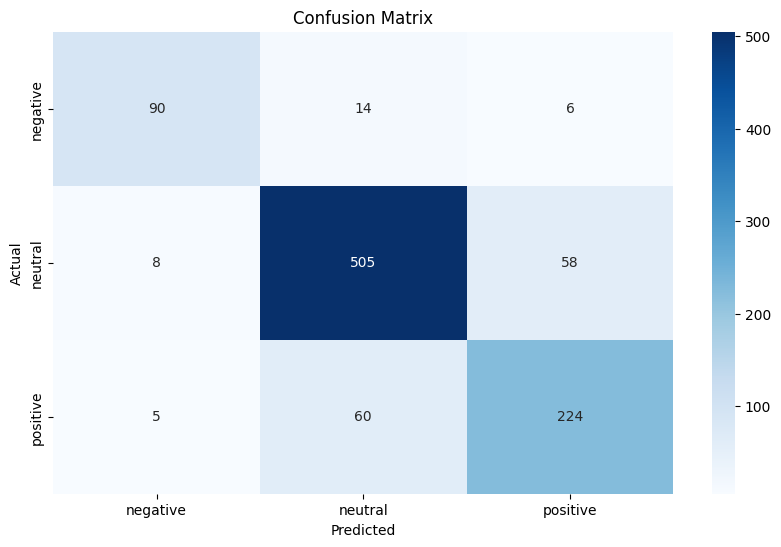

In [20]:
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [23]:
# 1. 모델 및 토크나이저 저장
model.save_pretrained("./saved_model")
tokenizer.save_pretrained("./saved_model")

# 2. 폴더 압축
import shutil
shutil.make_archive("saved_model", 'zip', "./saved_model")


'/sentiment/saved_model.zip'

In [24]:
from IPython.display import HTML

HTML('<a href="saved_model.zip" download> 모델 다운로드 (saved_model.zip)</a>')